In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [7]:
data_path = r'data/Fertility/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [8]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

# Parameter experiments

## Running experiments

Define parameters:

In [9]:
random_seed = 1038
scaling = True
oversampling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Define train and test splits:

In [10]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)

Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [11]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

Run the experiments, save the experiment results to csv and pickle:

In [12]:
models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

df_param.to_csv(r'results/fertility_params_experiments.csv', index=False)

with open(r'results/fertility_lists_experiments.pickle', 'wb') as handle:
    pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [119]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

results_df.to_csv("results/fertility_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 94...
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.05555556, 0.94444444]])

acc: 0.96
balanced_acc: 0.9565972222222222

Macro-averaged precision: 0.9565972222222222
Macro-averaged recall: 0.9565972222222222
Macro-averaged f-score: 0.9565972222222222
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 26...
Evaluation metrics:


array([[0.9375    , 0.0625    ],
       [0.05555556, 0.94444444]])

acc: 0.94
balanced_acc: 0.9409722222222222

Macro-averaged precision: 0.9312393887945671
Macro-averaged recall: 0.9409722222222222
Macro-averaged f-score: 0.9356499356499357
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 33...
Evaluation metrics:


array([[1.        , 0.        ],
       [0.05555556, 0.94444444]])

acc: 0.98
balanced_acc: 0.9722222222222222

Macro-averaged precision: 0.9848484848484849
Macro-averaged recall: 0.9722222222222222
Macro-averaged f-score: 0.9780219780219781
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 111...
Evaluation metrics:


array([[0.9375    , 0.0625    ],
       [0.11111111, 0.88888889]])

acc: 0.92
balanced_acc: 0.9131944444444444

Macro-averaged precision: 0.9131944444444444
Macro-averaged recall: 0.9131944444444444
Macro-averaged f-score: 0.9131944444444444
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 80...
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.05555556, 0.94444444]])

acc: 0.96
balanced_acc: 0.9565972222222222

Macro-averaged precision: 0.9565972222222222
Macro-averaged recall: 0.9565972222222222
Macro-averaged f-score: 0.9565972222222222
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


## Analysis

In [13]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['diverged'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

accuracy_threshold = df_param['test_score_mean'].max() * 0.5

In [14]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'diverged']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [15]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

vg_cols = [c for c in model_lists_df.columns if 'vanishing_gradients_' in c]
model_lists_df[f'vanishing_gradients'] = pd.Series(model_lists_df[vg_cols].values.tolist())
model_lists_df[f'vanishing_gradients'] = model_lists_df[f'vanishing_gradients'].apply(lambda x: sum(x))

In [16]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [17]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [18]:
max_accuracies_ids = df_param[df_param.any_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [19]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

In [20]:
color = [(127,201,127),(190,174,212),(253,192,134),(56,108,176),(255,255,153)]
for i, rgb in enumerate(color):
    r, g, b = rgb
    color[i] = r/255.0, g/255.0, b/255.0

from matplotlib.colors import ListedColormap
cmap = ListedColormap([color[3], color[2]])

### Sigmoid vs RELU

In [129]:
def get_specific_table(model_lists_melted_df, col, accuracy_threshold):
    df = model_lists_melted_df[model_lists_melted_df.metric_name.str.contains(col)].copy()
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    df.loc[:, 'cv'] = df.metric_name.str.extract(r'.*_cv(\d)').astype(int)
    df.loc[:, 'test_score_cv'] = df.apply(lambda x: x.test_score[x.cv], axis=1)
    df.loc[:, 'converged_cv'] = df.apply(lambda x: x.converged[x.cv], axis=1)

    df = df[(df.test_score_cv > accuracy_threshold) & df.converged_cv].copy()

    both_models_converged = pd.DataFrame(df.groupby(['model_short']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')

    return df

#### Fitting times

In [130]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time', accuracy_threshold=accuracy_threshold)

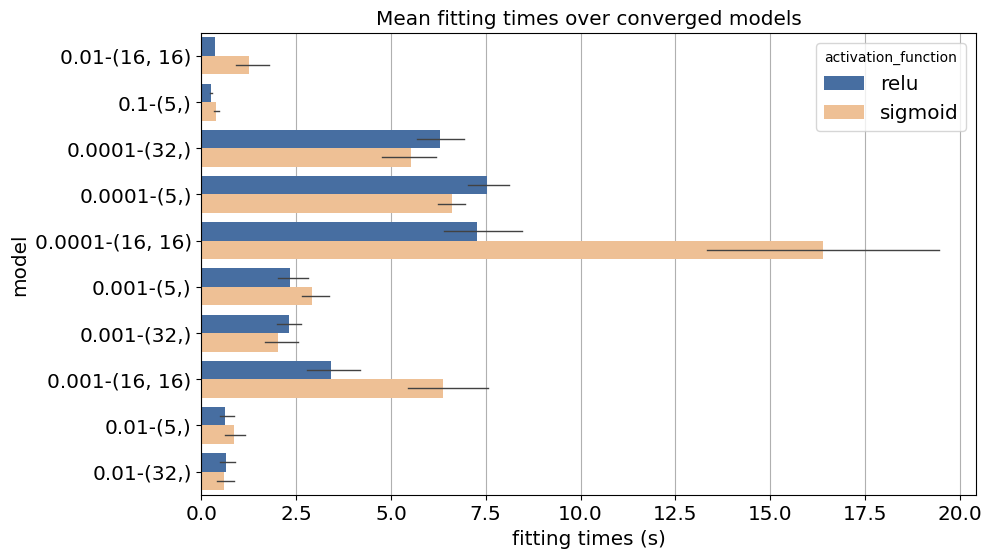

In [220]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")

In [140]:
max_accuracies_models.model.unique()

array(['MLP-relu-0.01-(5,)', 'MLP-sigmoid-0.01-(5,)',
       'MLP-relu-0.001-(10, 5, 5)', 'MLP-sigmoid-0.01-(10, 5, 5)',
       'MLP-relu-0.001-(16, 8, 8)', 'MLP-sigmoid-0.01-(16, 8, 8)',
       'MLP-relu-0.001-(16, 16)', 'MLP-sigmoid-0.001-(16, 16)',
       'MLP-relu-0.001-(32,)', 'MLP-sigmoid-0.001-(32,)',
       'MLP-relu-0.0001-(64, 32, 32)', 'MLP-sigmoid-0.01-(64, 32, 32)'],
      dtype=object)

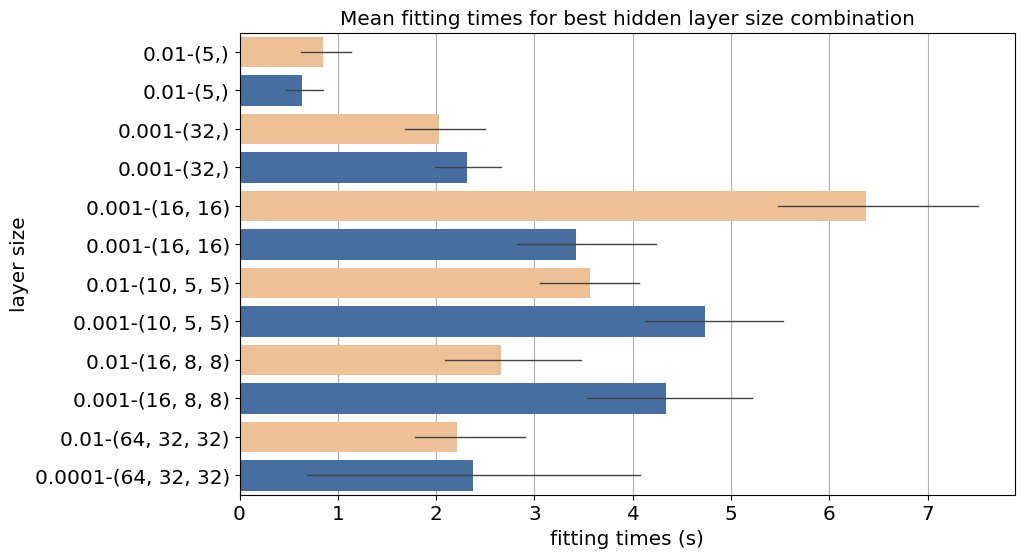

In [221]:
_, ax = plt.subplots(figsize=(10, 6))
df_fit_times_sorted = df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.unique())].copy()
df_fit_times_sorted['s2'] = df_fit_times_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_fit_times_sorted['s3'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_fit_times_sorted['s1'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_fit_times_sorted = df_fit_times_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_fit_times_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean fitting times for best hidden layer size combination', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Performance

In [144]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score', accuracy_threshold=accuracy_threshold)

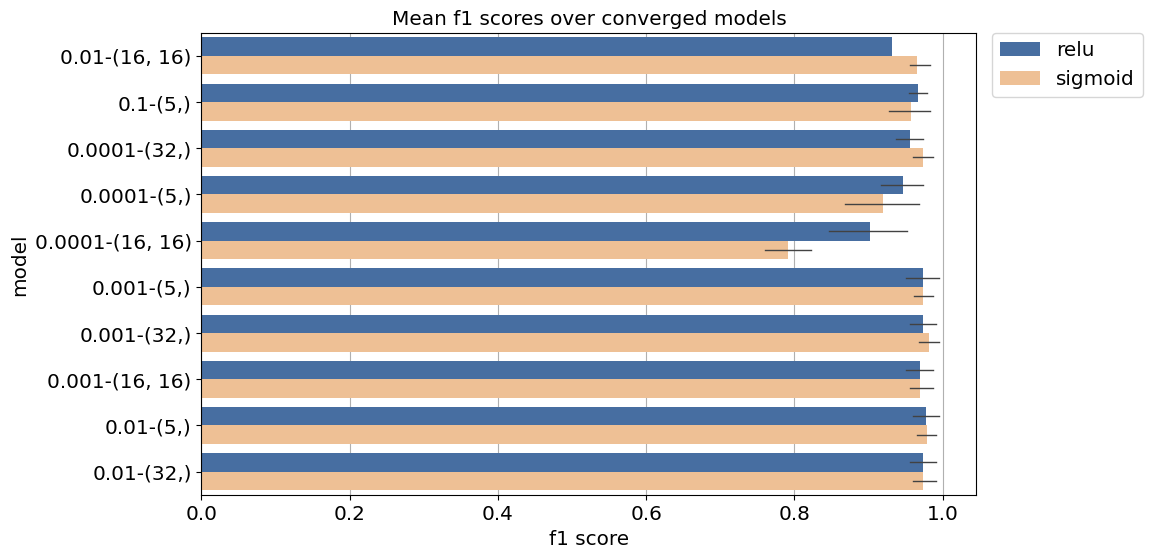

In [222]:
_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

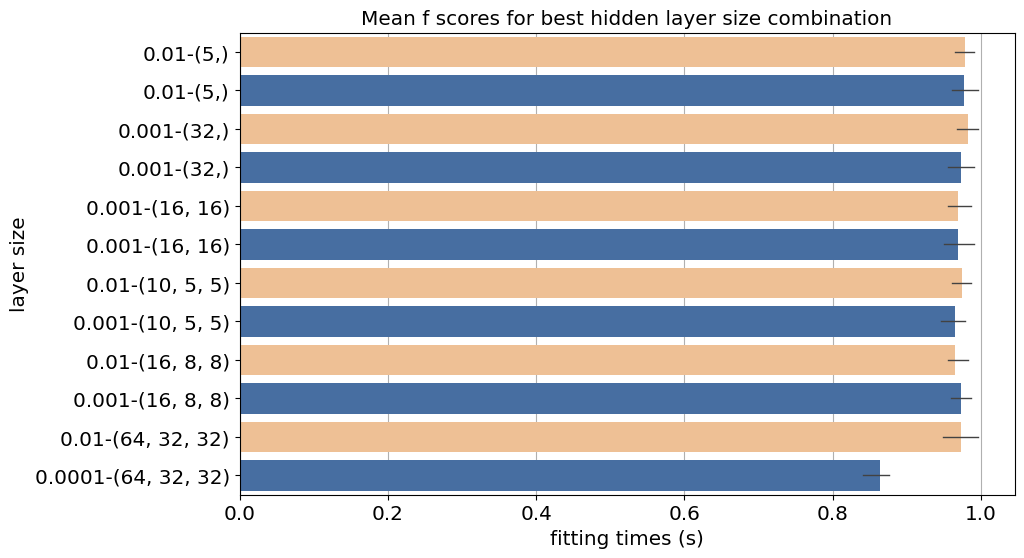

In [223]:
_, ax = plt.subplots(figsize=(10, 6))
df_test_scores_sorted = df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.unique())].copy()
df_test_scores_sorted['s2'] = df_test_scores_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_test_scores_sorted['s3'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_test_scores_sorted['s1'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_test_scores_sorted = df_test_scores_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_test_scores_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean f scores for best hidden layer size combination', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Convergence and vanishing gradients

Looking at gradients where accuracy is bad although training was not interrupted:

In [149]:
model_lists_df[model_lists_df[f'vanishing_gradients'] > 0]

,model,test_score,fit_time,score_time,converged,validation_losses,training_losses,gradients,converged_num,diverged,...,validation_losses_cv3,validation_losses_cv4,vanishing_gradients_cv0,vanishing_gradients_cv1,vanishing_gradients_cv2,vanishing_gradients_cv3,vanishing_gradients_cv4,vanishing_gradients,all_converged,any_converged
32,"MLP-sigmoid-0.0001-(16, 16)","[0.76, 0.39024390243902435, 0.3902439024390243...","[13.324634552001953, 3.333043336868286, 4.3011...","[0.0030739307403564453, 0.004683971405029297, ...","[True, True, True, True, True]","[[0.6846944249628928, 0.68041004553801, 0.6764...","[[0.6897664991801756, 0.6857423199092404, 0.68...","[{0: [1.0408340855860842e-18, -5.2041704279304...",5,0,...,"[0.6904524339288072, 0.6859974816707222, 0.681...","[0.695168945110558, 0.6906579219713207, 0.6864...",False,True,True,True,False,3,True,True
33,"MLP-sigmoid-0.0001-(10, 5, 5)","[0.39759036144578314, 0.39024390243902435, 0.3...","[0.590977668762207, 0.6155796051025391, 0.5031...","[0.0048139095306396484, 0.0029921531677246094,...","[True, True, True, True, True]","[[0.665360557095163, 0.664856986537459, 0.6643...","[[0.669389231513787, 0.6689505808248375, 0.668...","[{0: [5.551115123125782e-19, -1.04083408558608...",5,0,...,"[0.6660143799953616, 0.6654715856369968, 0.664...","[0.6661892134315389, 0.6656454424550936, 0.665...",True,True,True,True,True,5,True,True
34,"MLP-sigmoid-0.0001-(16, 8, 8)","[0.39759036144578314, 0.39024390243902435, 0.3...","[2.3677468299865723, 2.79422664642334, 2.40829...","[0.004060268402099609, 0.0030362606048583984, ...","[True, True, True, True, True]","[[0.7072278380211776, 0.704826609156837, 0.702...","[[0.7062144791748886, 0.7039923883672555, 0.70...","[{0: [-1.4311468676808658e-18, 8.4567769453869...",5,0,...,"[0.706704565922092, 0.7042237285465667, 0.7018...","[0.7070524321627435, 0.704577168767646, 0.7022...",True,True,True,True,True,5,True,True
35,"MLP-sigmoid-0.0001-(64, 32, 32)","[0.39759036144578314, 0.39024390243902435, 0.3...","[1.8049182891845703, 1.891944408416748, 2.2805...","[0.003992319107055664, 0.0033380985260009766, ...","[True, True, True, True, True]","[[0.7025572764811245, 0.6948739024060192, 0.68...","[[0.7210845882166167, 0.7126230487451936, 0.70...","[{0: [-1.1167282376600696e-18, 1.4853569763051...",5,0,...,"[0.7070232050882079, 0.6995576649009283, 0.693...","[0.70536412777116, 0.6978649743653895, 0.69132...",True,True,True,True,True,5,True,True
39,"MLP-sigmoid-0.001-(10, 5, 5)","[0.39759036144578314, 0.39024390243902435, 0.3...","[0.8025007247924805, 0.9098875522613525, 1.103...","[0.004088401794433594, 0.0031833648681640625, ...","[True, True, True, True, True]","[[0.6612898272776057, 0.6579077700351847, 0.65...","[[0.6658723700338122, 0.6630134247707815, 0.66...","[{0: [-3.226585665316861e-18, 5.89805981832114...",5,0,...,"[0.6616602445700919, 0.6580794399779766, 0.655...","[0.6618267338335757, 0.6582367708632013, 0.655...",True,True,True,True,True,5,True,True
40,"MLP-sigmoid-0.001-(16, 8, 8)","[0.39759036144578314, 0.39024390243902435, 0.3...","[1.5584259033203125, 0.976189136505127, 1.4186...","[0.0030059814453125, 0.003378629684448242, 0.0...","[True, True, True, True, True]","[[0.6887285072415693, 0.6749584658515791, 0.66...","[[0.6891988993043509, 0.6767463707952908, 0.66...","[{0: [-1.0842021724855044e-18, 1.3010426069826...",5,0,...,"[0.6877059429136898, 0.6737077104057319, 0.664...","[0.688093104436393, 0.6741178839526063, 0.6649...",True,True,True,True,True,5,True,True
57,"MLP-sigmoid-0.5-(10, 5, 5)","[0.39759036144578314, 0.39024390243902435, 0.3...","[0.5155467987060547, 0.5394723415374756, 0.660...","[0.003244161605834961, 0.003988027572631836, 0...","[True, True, True, True, True]","[[1.1057403195871907, 1.1908419858294979, 1.19...","[[1.143532122787749, 1.2321828707975788, 1.240...","[{0: [-4.531965080989411e-19, -1.7195446455620...",5,0,...,"[1.1142079723773872, 1.192218892205877, 1.1998...","[1.1124667970285809, 1.191237473613468, 1.1992...",True,T

In [212]:
g_id = 58
i = 4 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

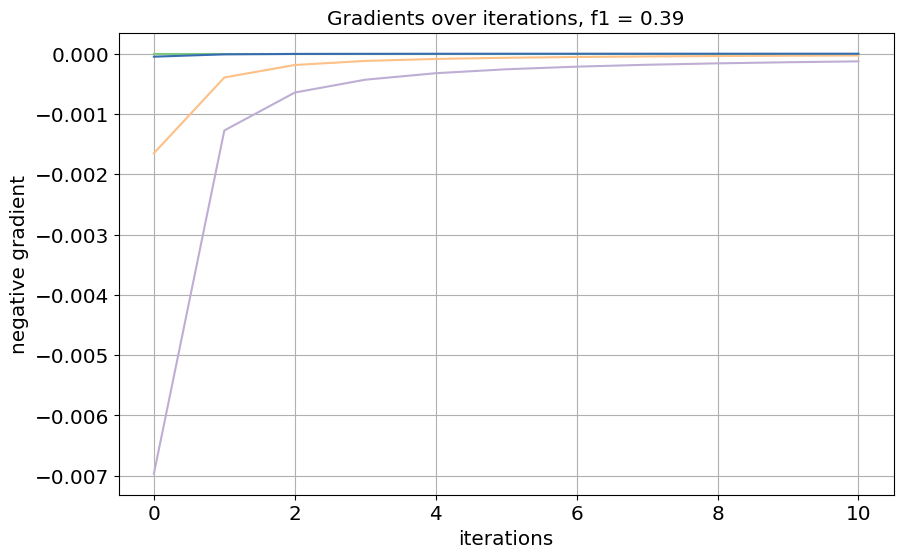

In [213]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

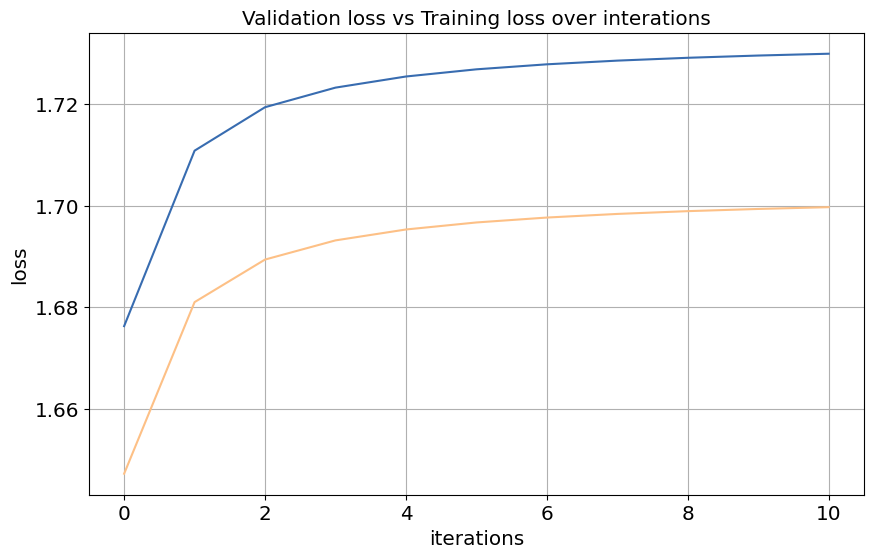

In [214]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [215]:
g_id = 58
i = 0 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

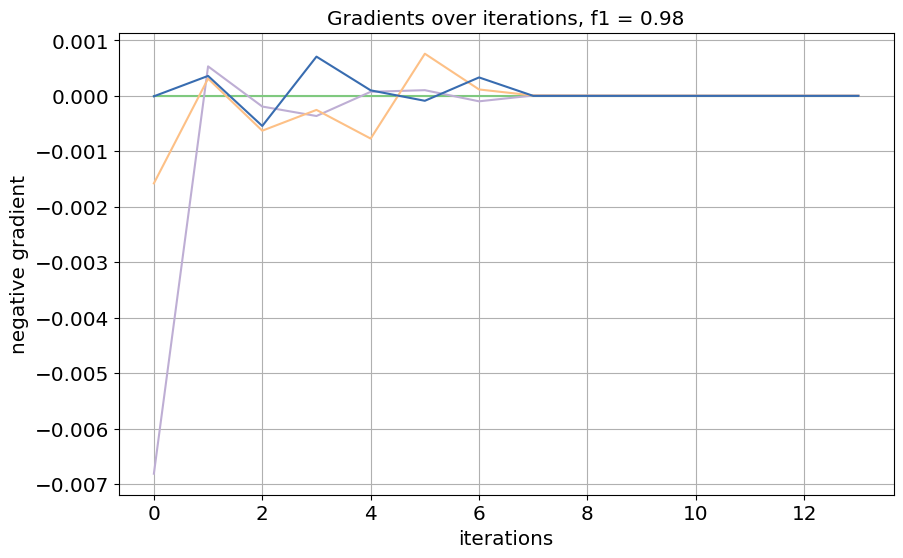

In [216]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

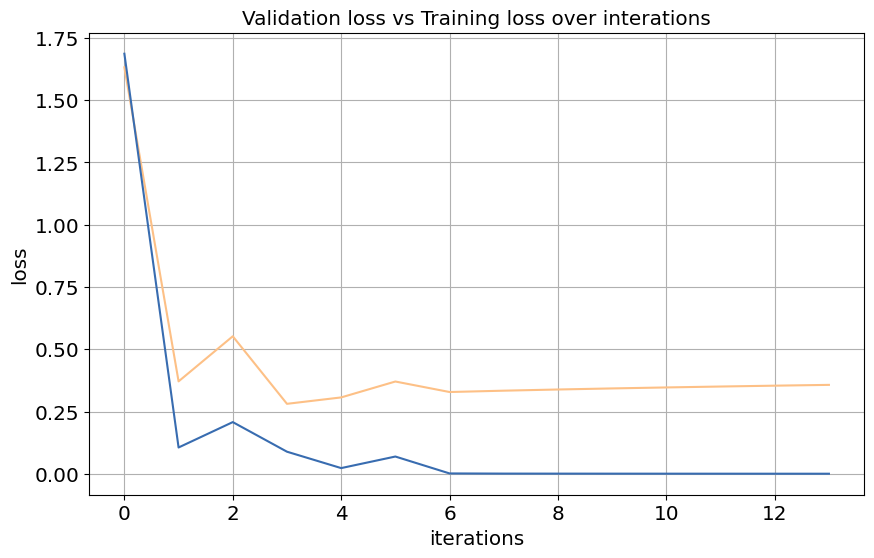

In [217]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [24]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


C:\Users\Alina\AppData\Local\Temp\ipykernel_4512\560291286.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


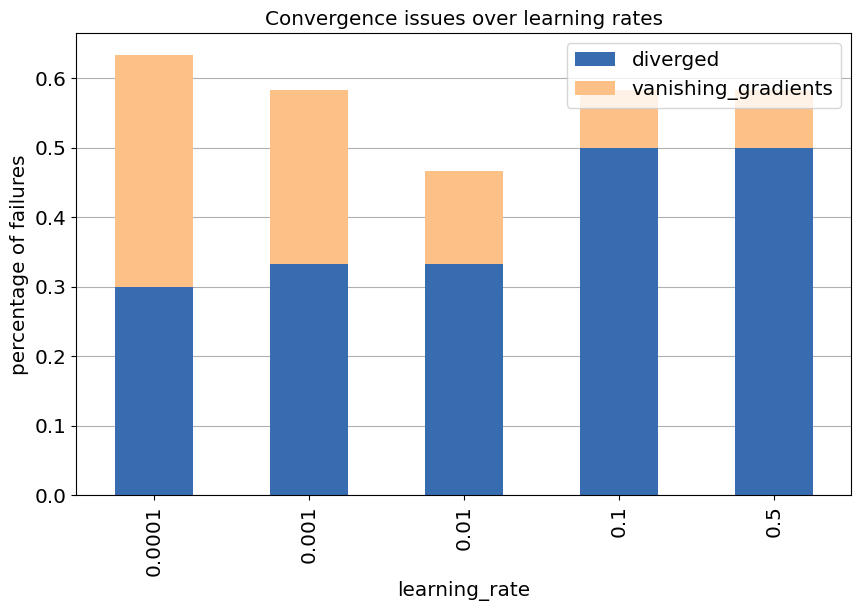

In [25]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
failure_count.plot(ax = ax, kind='bar', stacked=True, cmap=cmap)
ax.set(title=f'Convergence issues over learning rates', ylabel='percentage of failures')
ax.grid(axis='y')

In [22]:
def get_failure_df(model_lists_df, by_col='hidden_layer_sizes'):
    failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
    failure_count = failure_count.reset_index(drop=False)
    failure_count['layer_size_len'] = failure_count[by_col].apply(lambda x: len(x))
    failure_count = failure_count.sort_values(by='layer_size_len')
    failure_count = failure_count.drop('layer_size_len', axis=1)
    failure_count = failure_count.set_index(by_col)
    return failure_count

C:\Users\Alina\AppData\Local\Temp\ipykernel_4512\3839886018.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


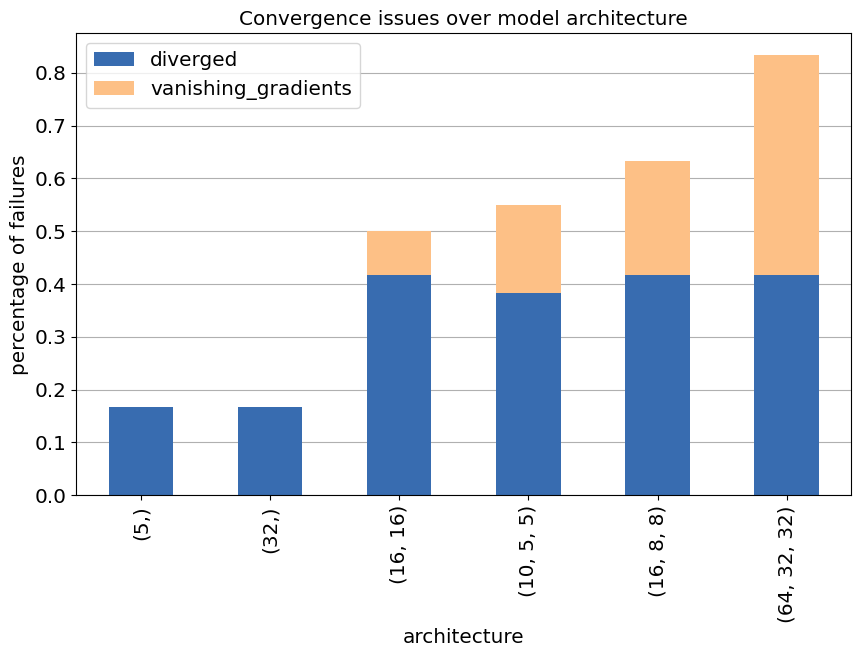

In [26]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = get_failure_df(model_lists_df, by_col='hidden_layer_sizes')
failure_count.plot(ax = ax, kind='bar', stacked=True, colormap=cmap)
ax.set(title=f'Convergence issues over model architecture', ylabel='percentage of failures', xlabel='architecture')
ax.grid(axis='y')